## Projeto de Modelo de Machine Learning para Detecção de Fraude

Para a criação desse modelo, serão utilizados dados da base de dados do Kaggle conhecida como **Fraud Detection Example**. Essa base de dados é uma fração de dados do **PaySim**, um simulador de dados financeiros muito usado para projetos voltados para detecção de fraude.

### Significado das Colunas

**step** - É uma unidade de tempo no mundo real. A cada "step" ou passo, significa 1 hora do tempo real. Ao todo, foram simulados 30 dias.

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT e TRANSFER.

**amount** - Valor da transação em moeda local.

**nameOrig** - Cliente que iniciou a transação.

**oldbalanceOrg** - Saldo inicial antes da transação.

**newbalanceOrig** - Saldo após a transação.

**nameDest** - Cliente destinatário da transação.

**oldbalanceDest** - Destinatário do saldo inicial antes da transação. Note que não há informações para clientes que começam com M (comerciantes).

**newbalanceDest** - Novo destinatário do saldo após a transação. Note que não há informações para clientes que começam com M (comerciantes).

**isFraud** - São transações feitas pelos agentes fraudulentos dentro da simulação. Nesse cenário simulado, o comportamento fraudulento dos agentes visa lucrar ao assumir o controle das contas dos clientes e tentar esvaziar os fundos transferindo para outra conta e depois realizando o saque do sistema.

**isFlaggedFraud** - O modelo de negócios visa controlar transferências massivas de uma conta para outra e sinaliza tentativas ilegais. Uma tentativa ilegal neste conjunto de dados é uma tentativa de transferir mais de 200.00 em uma única transação.

### Importações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Análise/manipulação Inicial

In [2]:
df = pd.read_csv('fraud_dataset_example.csv')

In [3]:
df = df[['isFraud',
       'isFlaggedFraud','step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest']]

In [4]:
df.head()

,isFraud,isFlaggedFraud,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,0,0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0
1,0,0,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0
2,1,0,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0
3,1,0,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0
4,0,0,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0


In [5]:
colunas = {
    'isFraud': 'fraude',
    'isFlaggedFraud': 'grande_fraude',
    'step': 'tempo', 
    'type': 'tipo', 
    'amount': 'valor', 
    'nameOrig': 'cliente_org', 
    'oldbalanceOrg': 'saldo_inicial_cliente_org', 
    'newbalanceOrig': 'saldo_novo_cliente_org',
    'nameDest': 'cliente_dest', 
    'oldbalanceDest': 'saldo_inicial_cliente_dest', 
    'newbalanceDest': 'saldo_novo_cliente_dest'
}

In [6]:
df = df.rename(columns = colunas)

In [7]:
df.describe().T #Sem NaN 

,count,mean,std,min,25%,50%,75%,max
fraude,101613.0,1.141586e-03,3.376824e-02,0.00,0.00,0.00,0.00,1.00
grande_fraude,101613.0,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00
tempo,101613.0,8.523457e+00,1.820681e+00,1.00,8.00,9.00,10.00,10.00
valor,101613.0,1.740901e+05,3.450199e+05,0.32,10016.59,53385.41,212498.40,10000000.00
saldo_inicial_cliente_org,101613.0,9.071753e+05,2.829575e+06,0.00,0.00,20190.47,194715.00,38939424.03
saldo_novo_cliente_org,101613.0,9.234992e+05,2.867319e+06,0.00,0.00,0.00,219217.76,38946233.02
saldo_inicial_cliente_dest,101613.0,8.810428e+05,2.399949e+06,0.00,0.00,21058.00,591921.70,34008736.98
saldo_novo_cliente_dest,101613.0,1.183998e+06,2.797761e+06,0.00,0.00,51783.43,1063121.64,38946233.02


Verificando a variável explicativa

In [8]:
df.groupby('fraude').tempo.count()

fraude
0    101497
1       116
Name: tempo, dtype: int64

### Sumarização dos Dados

In [60]:
cont_fraude = df['fraude'].value_counts()
proporcao_fraude = round(df['fraude'].value_counts(normalize=True) * 100, 2)

cont_grande_fraude = df['grande_fraude'].value_counts()
proporcao_grande_fraude = round(df['grande_fraude'].value_counts(normalize=True) * 100, 2)

cont_tipo = df['tipo'].value_counts()
proporcao_tipo = round(df['tipo'].value_counts(normalize=True) * 100, 2)

cont_grande_fraude = df['grande_fraude'].value_counts()
proporcao_grande_fraude = round(df['grande_fraude'].value_counts(normalize=True) * 100, 2)


fraude_por_tipo = df.groupby('tipo')['fraude'].mean() * 100

Ocorrências de Fraude e Grande Fraude

Text(0.5, 1.0, 'OCORRÊNCIA DE GRANDES FRAUDES')

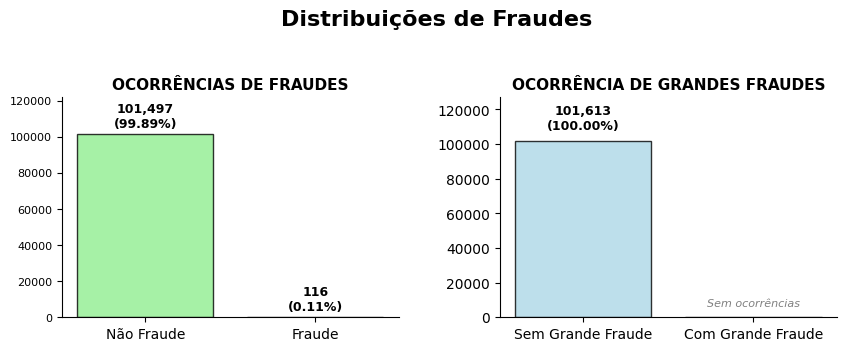

In [75]:
# Criação das figuras para os gráficos
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Distribuições de Fraudes', fontsize=16, fontweight='bold', y=0.99)

# Definir layout dos subplots
grid = plt.GridSpec(2, 2, hspace=0.8, wspace=0.3)

# Disposição dos Gráficos
ax1 = fig.add_subplot(grid[0, 0]) # Ocorrências de Fraudes
ax2 = fig.add_subplot(grid[0, 1]) # Ocorrências de Grandes Fraudes
[sns.despine(ax=ax, top=True, right=True) for ax in [ax1, ax2]]


# GRÁFICO 1: Distribuição de Fraude

bars1 = ax1.bar(['Não Fraude', 'Fraude'], cont_fraude.values, color=['lightgreen', 'lightcoral'], alpha=0.8, edgecolor='black')
ax1.set_title('OCORRÊNCIAS DE FRAUDES', fontsize=11, fontweight='semibold')
ax1.tick_params(axis='y', labelsize=8)
ax1.set_ylim(0, cont_fraude.max() * 1.2)

# Adicionar valores e percentuais
for bar, count, perc in zip(bars1, cont_fraude.values, proporcao_fraude.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (cont_fraude.max() * 0.02),
             f'{count:,}\n({perc:.2f}%)', ha='center', va='bottom', fontsize=9, fontweight='semibold')

    
# GRÁFICO 2: Distribuição de Grande Fraude

# Usar sempre os dois labels, mesmo se um valor for zero
labels = ['Sem Grande Fraude', 'Com Grande Fraude']
valores = [cont_grande_fraude.get(0, 0), cont_grande_fraude.get(1, 0)]

bars2 = ax2.bar(labels, valores, color=['lightblue', 'darkred'], alpha=0.8, edgecolor='black')

# Ajustar altura proporcionalmente
ax2.set_ylim(0, cont_grande_fraude.max() * 1.25)

# Adicionar valores (se for zero, mostra "0")
for i, (bar, count) in enumerate(zip(bars2, valores)):
    perc = (count / sum(valores)) * 100 if sum(valores) > 0 else 0
    if count > 0:  # Só mostra texto se houver valor
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (cont_grande_fraude * 0.05), f'{count:,}\n({perc:.2f}%)', ha='center', va='bottom', fontsize=9, fontweight='bold')
    else:  # Para valor zero, mostra mensagem discreta
        ax2.text(bar.get_x() + bar.get_width()/2, cont_grande_fraude * 0.05, 'Sem ocorrências', ha='center', va='bottom', fontsize=8, color='gray', style='italic')

ax2.set_title('OCORRÊNCIA DE GRANDES FRAUDES', fontsize=11, fontweight='bold')




Distribuição por Tipo de Transação e sua Porcentagem de ocorrências de Fraudes

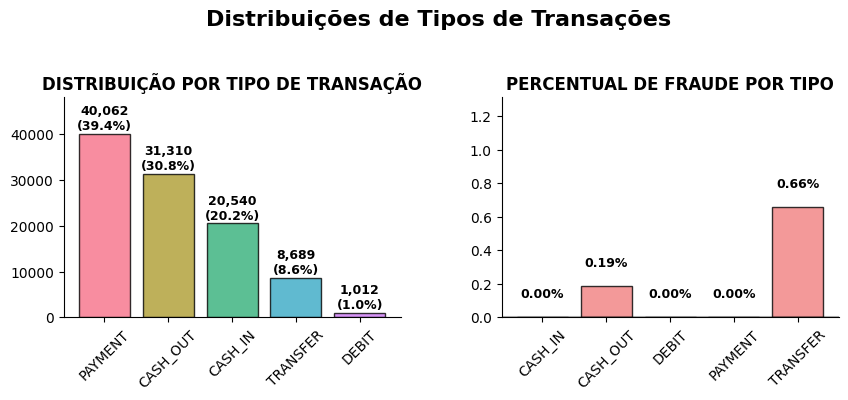

In [76]:
# Criação das figuras para os gráficos
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Distribuições de Tipos de Transações', fontsize=16, fontweight='bold', y=0.99)


# Definir layout dos subplots
grid = plt.GridSpec(2, 2, hspace=0.8, wspace=0.3)

# Disposição dos Gráficos
ax3 = fig.add_subplot(grid[0, 0]) # Tipos de Transação
ax4 = fig.add_subplot(grid[0, 1]) # Distribuição de Valores 
[sns.despine(ax=ax, top=True, right=True) for ax in [ax3, ax4]]


# GRÁFICO 3: Tipos de Transação

bars3 = ax3.bar(cont_tipo.index, cont_tipo.values, color=sns.color_palette("husl", len(cont_tipo)), alpha=0.8, edgecolor='black')
ax3.set_title('DISTRIBUIÇÃO POR TIPO DE TRANSAÇÃO', fontsize=12, fontweight='semibold')
ax3.tick_params(axis='x', rotation=45)
ax3.set_ylim(0, cont_tipo.max() * 1.2)

for bar, count, perc in zip(bars3, cont_tipo.values, proporcao_tipo.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() +  300, f'{count:,}\n({perc:.1f}%)', ha='center', va='bottom', fontsize=9, fontweight='semibold')
    

# GRÁFICO 4: Fraude por Tipo


bars4 = ax4.bar(fraude_por_tipo.index, fraude_por_tipo.values, color=['lightcoral' if x > 0 else 'lightblue' for x in fraude_por_tipo.values], alpha=0.8, edgecolor='black')
ax4.set_title('PERCENTUAL DE FRAUDE POR TIPO', fontsize=12, fontweight='semibold')
ax4.tick_params(axis='x', rotation=45)
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax4.set_ylim(0, fraude_por_tipo.max() * 2)

for bar, valor in zip(bars4, fraude_por_tipo.values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{valor:.2f}%', ha='center', va='bottom', fontsize=9, fontweight='semibold')
    
plt.show()

In [ ]:

ax5 = fig.add_subplot(grid[2, :]) # Fraude por Tipo
ax6 = fig.add_subplot(grid[3, :]) # Matriz de Correlação
ax7 = fig.add_subplot(grid[4, :]) # Estatísticas Descritivas




# GRÁFICO 5: Distribuição de Valores

# Usar escala log para melhor visualização
valores_log = np.log10(df['valor'] + 1)  # +1 para evitar log(0)

ax5.hist(valores_log, bins=50, color='lightseagreen', alpha=0.8, edgecolor='black')
ax5.set_title('DISTRIBUIÇÃO DOS VALORES (Escala Log)', fontsize=12, fontweight='bold')
ax5.set_xlabel('Log10(Valor + 1)', fontsize=10)
ax5.set_ylabel('Frequência', fontsize=10)
ax5.grid(True, alpha=0.3)

# Adicionar estatísticas no gráfico
stats_text = f"""Estatísticas dos Valores:
Média: R$ {df['valor'].mean():.2f}
Máximo: R$ {df['valor'].max():.2f}
Mínimo: R$ {df['valor'].min():.2f}
Desvio: R$ {df['valor'].std():.2f}"""
ax5.text(0.02, 0.98, stats_text, transform=ax5.transAxes, fontsize=8, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))


# GRÁFICO 6: Matriz de Correlação
num_colunas = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[num_colunas].corr()

im = ax6.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
ax6.set_title('MATRIZ DE CORRELAÇÃO ENTRE VARIÁVEIS NUMÉRICAS', fontsize=12, fontweight='bold')
ax6.set_xticks(range(len(num_colunas)))
ax6.set_yticks(range(len(num_colunas)))
ax6.set_xticklabels(num_colunas, rotation=45, ha='right', fontsize=8)
ax6.set_yticklabels(num_colunas, fontsize=8)

# Adicionar valores na matriz
for i in range(len(num_colunas)):
    for j in range(len(num_colunas)):
        text = ax6.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', ha="center", va="center", color="black", fontsize=7, fontweight='bold')

# Barra de cores
cbar = plt.colorbar(im, ax=ax5, shrink=0.8)
cbar.set_label('Coeficiente de Correlação', fontsize=10)

# ===== GRÁFICO 6: Estatísticas Descritivas =====
ax6.axis('off')  # Desativar eixos

# Pegar estatísticas descritivas
desc_stats = df.describe().T.round(2)
table_data = [['Variável'] + list(desc_stats.columns)] + \
             [[idx] + list(row) for idx, row in desc_stats.iterrows()]

# Criar tabela
table = ax6.table(cellText=table_data, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(7)
table.scale(1.2, 2)

ax6.set_title('ESTATÍSTICAS DESCRITIVAS - RESUMO NUMÉRICO', fontsize=12, fontweight='bold', pad=20)

# ===== INFO GERAIS =====
# Adicionar informações gerais como texto
info_text = f"""INFORMAÇÕES GERAIS:
• Total de Transações: {len(df):,}
• Transações Normais: {cont_fraude[0]:,} ({proporcao_fraude[0]:.4f}%)
• Transações Fraudulentas: {cont_fraude[1]:,} ({proporcao_fraude[1]:.4f}%)
• Tipos de Transação: {', '.join(cont_tipo.index.tolist())}
• Data de Análise: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}"""

fig.text(0.02, 0.02, info_text, fontsize=9, verticalalignment='bottom',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()


IndexError: GridSpec slice would result in no space allocated for subplot